In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact
import ipywidgets as ipyw

In [3]:
az.style.use('arviz-white')

On chapter 3 we introduced linear models for multiple linear regression. The models we discussed had the general form:

$$\mu = \alpha + \beta_0 x_0 + \beta_1 x_1 \cdots + \beta_n x_n \tag{1}$$

that is, out of $n$ total variables we take each $i$ variable and we multiply it by a $\beta_i$ coefficient, resulting in a total of $n$ terms (plus the intercept $\alpha$) that we sum together to obtain the predicted value of $\mu$.

We saw we can interpret each $\beta_i$ coefficient as the slope of a line, that is how much $\mu$ changes per unit change of $x_i$. Each term contributes in an independent fashion to the final value of $\mu$. You can see this in the following interactive figure, just let `b2` fixed at 0 and try changing the values of `b0` and `b1`, you will see that you get a plane with `b0` controlling the slope along the $x_0$ axis and `b1` doing the same for along the $x_1$ axis.

<IPython.core.display.Javascript object>


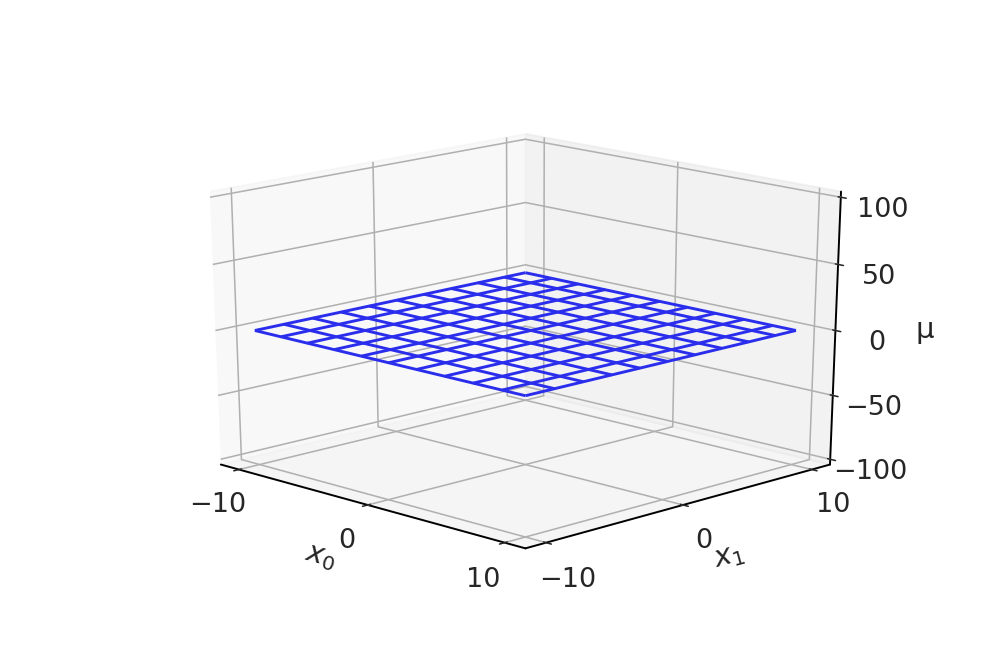

interactive(children=(FloatSlider(value=0.0, description='b0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [4]:
x = np.linspace(-10, 10)

X0, X1 = np.meshgrid(x, x)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-45)


def update(b0, b1, b2):
    ax.clear()
    Y = X0 * b0 + X1 * b1 + b2 * (X0 * X1) 
    # Plot a basic wireframe.
    line = ax.plot_wireframe(X0, X1, Y, rstride=5, cstride=5)
    ax.set_zlim(-100, 100)
    ax.set_xticks([-10, 0, 10])
    ax.set_yticks([-10, 0, 10])
    ax.set_zticks([-100, -50, 0, 50, 100])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('μ')


interact(update,
         b0=ipyw.FloatSlider(min=-5, max=5, step=0.1, value=0),
         b1=ipyw.FloatSlider(min=-5, max=5, step=0.1, value=0),
         b2=ipyw.FloatSlider(min=-1, max=1, step=0.1, value=0));

## Adding interactions

We can expand linear models by adding **interaction** terms. One common option to do so is to multiply variables, for example:

$$\mu = \alpha + \beta_0 x_0 + \beta_1 x_1 + \beta_2 x_0x_1 \tag{2}$$
    
    
Notice that the $\beta_2$ coefficient is multiplying a third, made-up, variable which is the product of $x_0$ and $x_1$. 

To better understand the effect of this interaction term you can go back to the previous figure and change the value of $\beta_2$. You will be able to see that the _plane_ is not flat anymore! The reason is that the slope along the $x_0$ axis is not longer constant for different values of $x_1$, quite the opposite the value of the slope is conditional on the values of the variable $x_1$. When the value of $\beta_2$ is positive you should observe that for _low_ values of $x_1$ the slope along $x_0$ axis is negative and becomes less and less pronounced for larger values of $x_1$, in fact it will eventually become positive. To see this more clear try rotating rotating the figure to get a better view. I suggest you see the plot along the $x_1$ axis using this view `ax.view_init(elev=0, azim=-90)`.

### Difficulties of using interactions

Interpreting linear models with interactions is not as easy as interpreting linear models
without them. We can see this by rewriting expression 2 in this notebook (or 3.21 in the book):

$$
\mu = \alpha + \underbrace{{(\beta_0 + \beta_2} x_1)} _ {\text{slope of } x_0} x_0 + \beta_1 x_1 \tag{3}
$$
$$
\mu = \alpha + \beta_0 x_0 + \underbrace{(\beta_1 + \beta_2 x_0)} _ {\text{slope of } x_1} x_1 \tag{4}
$$

This shows us the following:

* The interaction term can be understood as a linear model. Thus, the expression for the mean is a linear model with a linear model inside of it!

* The interaction is symmetric; we can think of it as the slope of  $x_0$ as a function of $x_1$ and at the same time as the slope of $x_1$ as a function of $x_2$. This can also be seen from the interactive figure. In terms of the tip-smoker example, we can say that the tip is affected by whether the customer is in a smoker or non-smoker section, or that being in the smoker or non smoker section depends on how much tip a customer is willing to give.

* We know from before that the $\beta_0$ coefficient can be interpreted as the amount on change of $\mu$ per unit change of $x_0$ (that is why we call it the _slope_). If we add and interaction terms, then this is only true at $x_1 = 0$. Try using the animated figure to see this by yourself.  Mathematically, this is true because when $x_1 = 0$ then $\beta_2x_1 = 0$, and thus the slope of $x_0$ reduces to $\beta_0 x_0$. By symmetry, the same reasoning can be applied to $\beta_1$.

## Tips and smokers

To further get intuition into the meaning of interactions we are going to use the tips dataset. We want to model the amount of tip as a function of the total bill. This sounds reasonable for a linear model given that the amount of the tip is generally calculated as a percentage of the total bill. With the exact percentage varying by different factors like the kind of place you are eating, the quality of the service, the country you are living, etc. Here we are going to explore the effect of the customers being on the smoker section vs the non-smoker section. Remember this is just a toy dataset, so the take home message should be about modeling interactions and not about tips. 

To help us understand interactions we are going begin by building two models. 

* A linear model for two variables `total_bill` and `smoker`. We will call it `model_nonint`
* A linear model for two variables `total_bill` and `smoker` plus and interaction term. We will call it `model_int`.

`total_bill` is a continuous variable and `smoker` is a binary one, we will use 0 for non-smokers and 1 for smokers. 

Let's upload to the data into a DataFrame.

In [5]:
tips = pd.read_csv('../code/data/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


We give the data a gentle massage, including centering the variable `total_bill` and then we plot it.

<IPython.core.display.Javascript object>


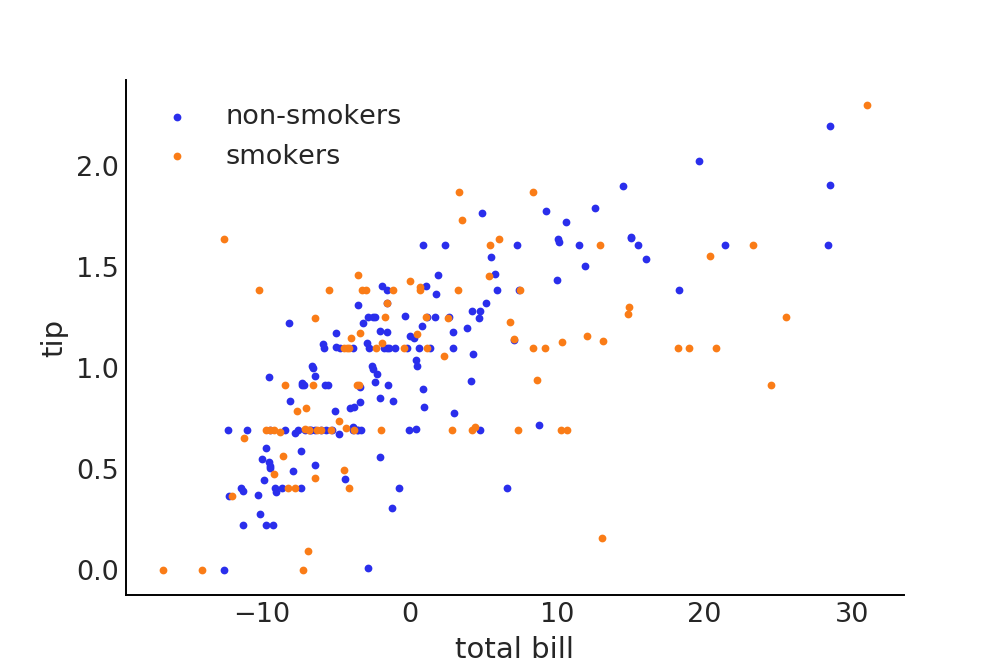

In [6]:
y = np.log(tips.tip)
x0 = (tips.total_bill - tips.total_bill.mean())  
x1 = pd.Categorical(tips.smoker).codes

def plot_data():
    _, ax = plt.subplots()
    ax.scatter(x0[x1==0], y[x1==0], label='non-smokers', marker='.')
    ax.scatter(x0[x1==1], y[x1==1], label='smokers', marker='.')
    ax.set_xlabel('total bill')
    ax.set_ylabel('tip')
    ax.legend()
    return ax
    
plot_data();

In [7]:
with pm.Model() as model_nonint:
    α = pm.Normal('α', mu=tips.tip.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    σ = pm.HalfNormal('σ', 1)

    μ = (α +
         β[0] * x0 + 
         β[1] * x1)

    obs = pm.Normal('obs', μ, σ, observed=y)
    trace_nonint = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1619.44draws/s]


First, we are going to explore the results visually, to do so we are going to plot the data together with the mean linear fit for non-smokers (blue) and smokers (orange).

<IPython.core.display.Javascript object>


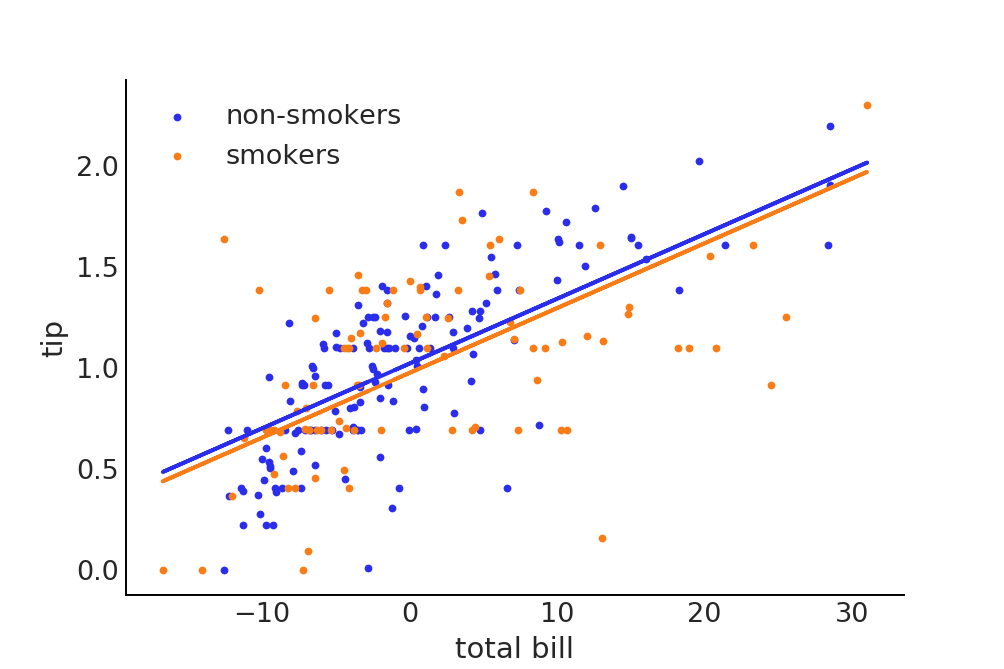

In [8]:
α_nonint = trace_nonint['α']
β0_nonint = trace_nonint['β'][:,0]
β1_nonint = trace_nonint['β'][:,1]

pred_y_non_smokers = α_nonint + β0_nonint * x0[:,None]
pred_y_smokers = α_nonint + β0_nonint * x0[:,None] + β1_nonint

ax = plot_data()
ax.plot(x0, pred_y_non_smokers.mean(1), lw=2)
ax.plot(x0, pred_y_smokers.mean(1), lw=2);
#az.plot_hpd(x0, pred_x0.T, color='C0')
#az.plot_hpd(x0, pred_x1.T);

In the preceding figure we can see that we got two parallel lines, one for smokers and one for non-smokers. This is equivalent to say that the slopes of both lines are the same. The effect of including the variable `smokers` is just to _shift_ the smokers line. In this particular case the _shift_ is downwards because the mean of the parameter $\beta_1$ is negative. The reason we get the parallel lines is a consequence of how we formulate the linear model, this is more clear if we rewrite expression 1 for the two possibles values of the variable $x_1$:

$$
\mu = \begin{cases} \alpha + \beta_0 x_0 &\mbox{if } x_1 = 0 \\
\alpha + \beta_0 x_0 + \beta_1 &\mbox{if } x_1 = 1 \end{cases} \tag{5}
$$

Which explains why, in the previous block of code, we wrote:

```python
pred_x1 = α_nonint + β0_nonint * x1[:,None]
pred_x2 = α_nonint + β0_nonint * x1[:,None] + β1_nonint
```+
Now we are going to write `model_int`. Compared to `model_noint` the differences are:

* $\beta$ has `shape=3`
* the expression for $\mu$ has one more term, the interaction term.

In [9]:
with pm.Model() as model_int:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=3)
    σ = pm.HalfNormal('σ', 1)

    μ = (α +
         β[0] * x0 +
         β[1] * x1 +
         β[2] * x0*x1)

    obs = pm.Normal('obs', μ, σ, observed=y)
    trace_int = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1331.86draws/s]


As we did with `model_noint` we plot the data together with the mean linear fit for non-smokers (blue) and smokers (orange), this plot also has the HPD 96% interval.

<IPython.core.display.Javascript object>


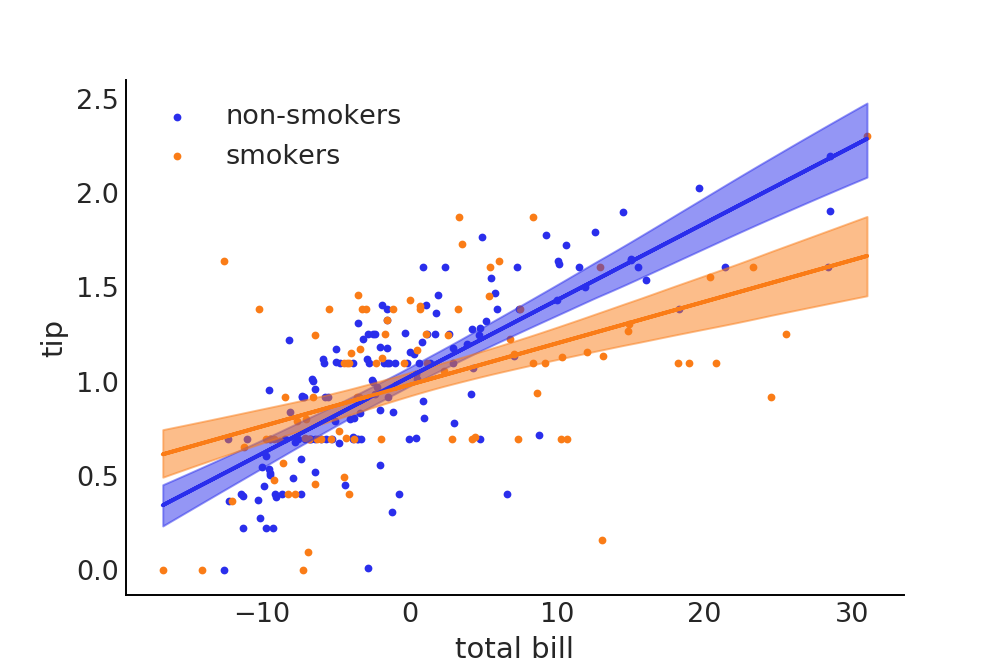

In [10]:
α_int = trace_int['α']
β0_int = trace_int['β'][:, 0]
β1_int = trace_int['β'][:, 1]
β2_int = trace_int['β'][:, 2]

# Because x2 is zero I am ommiting the terms multiplied my x2
pred_y_non_smokers = (α_int +
                      β0_int * x0[:, None])

# Because x2 is one I am ommiting x2
pred_y_smokers = (α_int +
                  β0_int * x0[:, None] +
                  β1_int +
                  β2_int * x0[:, None])


ax = plot_data()
ax.plot(x0, pred_y_non_smokers.mean(1), lw=2)
ax.plot(x0, pred_y_smokers.mean(1), lw=2)
az.plot_hpd(x0, pred_y_non_smokers.T, color='C0')
az.plot_hpd(x0, pred_y_smokers.T);

In [11]:
az.summary(trace_nonint)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,1.02,0.03,0.0,0.97,1.07,1493.0,1.0
β[0],0.03,0.00,0.0,0.03,0.04,1670.0,1.0
β[1],-0.05,0.04,0.0,-0.12,0.04,1505.0,1.0
σ,0.33,0.01,0.0,0.31,0.36,2272.0,1.0


Now the mean fitted lines are not longer parallel, the slopes for smokers and non-smokers is now different! By introducing an interaction we are building a model that is effectively splitting the data, in this example into two categories, `smoker` and `non-smokers`. 

You may be thinking that is better idea to you just split the data manually and fit two separated models, one for the smokers and one for the non-smokers. Well, not that fast. There is one advantage of using interactions. The main benefit is that we are using all the available data to fit a single model, increasing the accuracy of the estimated parameters. For example notice that by using a single model we are assuming that $\sigma$ is not affected by the variable `smoker` and thus $\sigma$ is estimated from both smokers and non smokers, helping us to get a more accurate estimation of this parameter. Using interactions is a way to put more structure in a model in a similar fashion as using hieralchical models is also a way to structure a model. Another benefit is that we get an estimation of the size effect of the interaction. If we just split the data we are implicitly assuming the interaction is exactly 0, by modeling the interaction we get an estimate about _how strong_ the interaction is. Finally this make easier to compare models using WAIC or LOO. If we split the data we end-up with different models evaluated on different data, instead of different models evaluated on the same data, which is a requisite for using WAIC or LOO. If you are not familiar with model comparison you can check chapter 5 of the book and/or the [PyMC3 documentation](https://docs.pymc.io/notebooks/model_comparison.html).

As we already said trying to interpret the coefficients of a linear model with interactions is a little bit more difficult than without interactions. Let see a few example so you do not have to just believe my word.

A summary of the posterior values of the parameters is:

In [12]:
az.summary(trace_int)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,1.02,0.03,0.0,0.98,1.08,1575.0,1.0
β[0],0.04,0.00,0.0,0.03,0.05,1816.0,1.0
β[1],-0.04,0.04,0.0,-0.12,0.04,1569.0,1.0
β[2],-0.02,0.00,0.0,-0.03,-0.01,1838.0,1.0
σ,0.32,0.01,0.0,0.29,0.35,1966.0,1.0


In this `summary` $\alpha$ is the expected tip when the variables `total_bill` and `smokers` take the value zero. This happens for the average value of `total_bill` (because we center this variable) and for non-smokers (we use zero to encode non-smokers). That is, $\alpha$ is the intercept only for the non_smokers.

Now we are going to compute the intercepts for the smokers and non_smokers lines from the sampled posterior. We are going to see 3 alternative ways to do this.

The first attempt follows from the fact that the intercept is the value of `pred_y_non_smokers` or `pred_y_smokers`, when `x0=0`. Here instead of having exactly `x0=0` we settle for a _close enough_ number.

In [13]:
ϵ = 0.02
intercept_non_smokers = pred_y_non_smokers[abs(x0.values) < ϵ]
intercept_smokers = pred_y_smokers[abs(x0.values) < ϵ]

f'{intercept_non_smokers.mean():.2f}, {intercept_smokers.mean():.2f}'

'1.02, 0.98'

As we can see the value of $\alpha$ from `az.sumary` is equal to the value of `intercept_non_smokers`, in line with our previous description of $\alpha$. Also notice that the value of `intercept_smokers` is different from the value of $\alpha$ in fact is smaller in agreement with the previous plot.

A second way to compute `intercept_smokers` follows from equation 2, if you inspect it carefully you will notice that when `x0=0` and `x1=1` the intercept is $\alpha + \beta_1$, using Python we can compute it like this:

In [14]:
f'{(α_int + β1_int).mean():.2f}'

'0.98'

Notice that this second method of computing the intercept is more reliable as depends directly on the posterior samples, while the first method depends also on the value of $\epsilon$ and on `x0` having a value close enough to zero.

The third option is somehow a hybrid of the first two, we want to compute the value of `pred_y_smokers` for `x0=0`, like in the first option, so we can write:

```python
x0 = 0
pred_y_smokers = (α_int +
                  β0_int * x0 +
                  β1_int +
                  β2_int * x0)
```

Which is equivalent to:


```python 
pred_x1 = α_int + β1_int
```

And this is exactly what we use in the second alternative.

Now let do something similar with $\beta_0$ from `az.summary`. $\beta_0$ is the expected change in the value of `tip` when `total_bill` increase one dollar and `smoker` is zero. That is, $\beta_0$ is the slope for the non_smokers. 

One way to verify this, is by computing the slope directly from the values of `pred_y_non_smokers_` and the values of `x0`, from these values the slope can be computed as:

$$slope = \frac{\Delta y}{\Delta x} = \frac{y_{max} - y_{min}}{x_{max} - x_{min}}$$

In [15]:
x0_ = x0.values
pred_y_non_smokers_ = pred_y_non_smokers.mean(1)
pred_y_smokers_ = pred_y_smokers.mean(1)
idx = np.argsort(x0_)
Δ_x = x0_[idx][-1] - x0_[idx][0]

slope_non_smokers = (pred_y_non_smokers_[idx][-1] - pred_y_non_smokers_[idx][0]) / Δ_x

slope_smokers = (pred_y_smokers_[idx][-1] - pred_y_smokers_[idx][0]) / Δ_x

f'{slope_non_smokers:.2f}, {slope_smokers:.2f}'

'0.04, 0.02'

We can see that $\beta_0$ is equal to `slope_non_smokers` and different from `slope_smokers`, in fact is smaller as expected from the previous plot. We can compute `slope_smokers`, that is the expected change in `tips` ($x_0$) for smokers ($x_1 = 1$) from equation 3:

In [16]:
(β0_int.mean() + β2_int.mean() * 1) 

0.022046650977570355

I hope this has not only convinced you but also help you to understand that interpreting the coefficients of a linear model with interactions is something that has to be done carefully. Now we are going to see one example of interactions between two continuous variables. 

## Interactions with continuous variables 

In the previous example the interaction term involves a continuous variable, `total_bill`, and a discrete variable, `smoker`. We find out that this implies a model with two slopes one per category. Now we are going to build a model with an interaction term between two continuous variables. From the model-building perspective there is no difference with the previous example, but interpreting and visualizing the results can be more challenging as we don't have just two discrete categories but a continuous variable (or infinite categories if you want).

For this example we are goint to use a reduced version of the [Concrete Compressive Strength Data Set](http://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)

We are going to upload the data and standardize it with the following code:

In [17]:
cc = pd.read_csv('concrete.csv')
cc = (cc - cc.mean()) / cc.std()
cc.head()

,CCS,cement,water
0,2.644123,2.476712,-0.916319
1,1.560663,2.476712,-0.916319
2,0.266498,0.491187,2.174405
3,0.313188,0.491187,2.174405
4,0.507732,-0.790075,0.488555


In [18]:
with pm.Model() as model_con:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=100, shape=3)
    σ = pm.HalfNormal('σ', 25)

    μ = (α +
         β[0]*cc.water +
         β[1]*cc.cement +
         β[2]*cc.water*cc.cement)

    y = pm.Normal('y', μ, σ, observed=cc.CCS)
    trace_con = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 942.34draws/s] 


In this new example $x_1$ is a continuous variable thus we can not just make a plot for each "category" as with the first example. Instead we can make a panel with several subplots for a few selected values of one of the two variables. Also we can do an interactive plot as we will do next.

The following interactive plot shows the values of `cement` vs `CCS` for a fixed value of water, you can use the slider to change the value of `water` and update the plot. Notice not only that the slope change, but also how the HPD 96% is updated. Optionally you can check the "scatter" box to see a scatter plot where the displayed datapoints correspond to the data within an interval of $\pm 1$ of the select value of the variable `water`. 

<IPython.core.display.Javascript object>


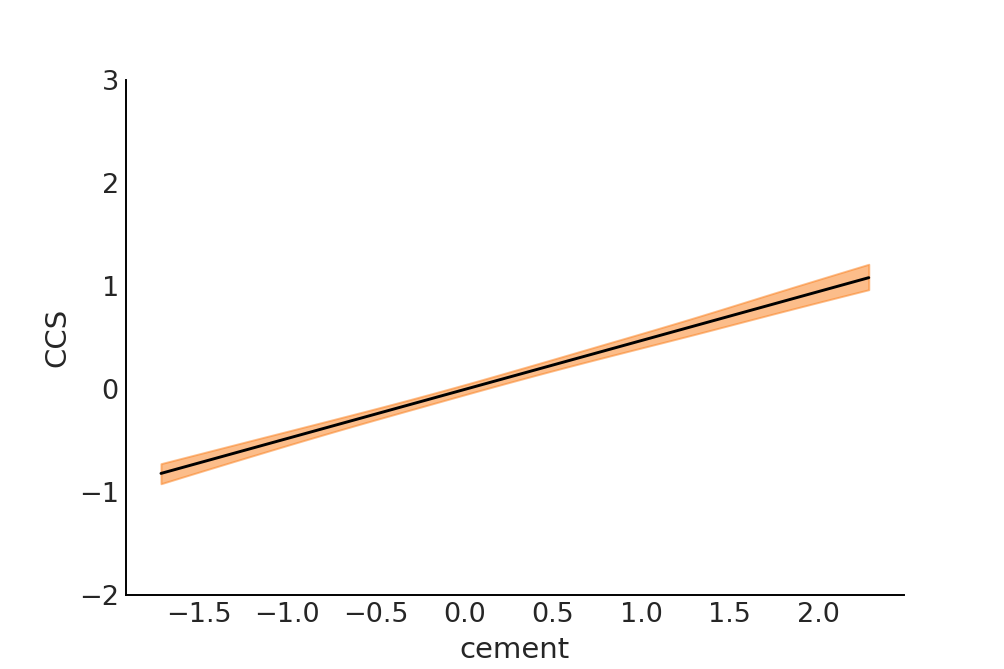

interactive(children=(FloatSlider(value=0.0, description='w', max=3.0, min=-3.0, step=1.0), Checkbox(value=Fal…

In [19]:
_, ax = plt.subplots()
cement_range = np.arange(cc.cement.min(), cc.cement.max(), 0.5)

α_post = trace_con['α']
β_post = trace_con['β']


def update(w, scatter):
    ax.clear()
    if scatter:
        cc_sub = cc[abs(cc.water - w) < 1]
        ax.plot(cc_sub.cement, cc_sub.CCS, 'C0.', label=f'water = {w}')
        ax.legend(loc=2)
    mu = (α_post +
          β_post[:, 0] * w +
          β_post[:, 1] * cement_range[:, None] +
          β_post[:, 2] * w * cement_range[:, None])

    ax.plot(cement_range, mu.mean(1), 'k')
    az.plot_hpd(cement_range, mu.T, ax=ax)
    ax.set_ylim(-2, 3)
    ax.set_ylabel('CCS')
    ax.set_xlabel('cement')


interact(update,
         w=ipyw.FloatSlider(min=-3,
                            max=3, step=1, value=0),
         scatter=False);

## Exercises

1) Just for fun let's change the first interactive and use the following expressions as interactions terms.
 
* b2 * (X0 * X1**2) / 10 
* b2 * (X0**2 * X1**2) / 100
* b2 * (X0 + X1)
* b2 * (X0 * X1 - X0**2)

2) Try using WAIC/LOO to compare `model_int` and `model_noint`. How to use and interpret WAIC/LOO is explained in chapter 5 of the book. Alternative you will find a quick intro [here](https://docs.pymc.io/notebooks/model_comparison.html)

3) For models `model_int` and `model_noint` try plotting the results with `tip` on the y-axis and `smoker` on the x-axis, include the datapoints and the fitted lines. Try to interpret the parameters of the model in terms of these new plots.

4) Plot `CCS` vs `water` using an interactive plot and use the slider to change the value of `cement` 

5) Create the non-interaction version of `model_con` and explore the result with the interactive plot. 